<a href="https://colab.research.google.com/github/Joffreybvn/road-accident-belgium-analysis/blob/master/Road_accident_Belgium_2019_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs & imports

In [ ]:
# Dataset download
!wget -N https://github.com/Joffreybvn/road-accident-belgium-analysis/blob/master/datasets/raw/TF_ACCIDENTS_2019.xlsx?raw=true
!wget -N https://raw.githubusercontent.com/Joffreybvn/road-accident-belgium-analysis/master/datasets/raw/BELGIUM-Municipalities.geojson

--2020-09-26 15:43:52--  https://github.com/Joffreybvn/road-accident-belgium-analysis/blob/master/datasets/raw/TF_ACCIDENTS_2019.xlsx?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Joffreybvn/road-accident-belgium-analysis/raw/master/datasets/raw/TF_ACCIDENTS_2019.xlsx [following]
--2020-09-26 15:43:52--  https://github.com/Joffreybvn/road-accident-belgium-analysis/raw/master/datasets/raw/TF_ACCIDENTS_2019.xlsx
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Joffreybvn/road-accident-belgium-analysis/master/datasets/raw/TF_ACCIDENTS_2019.xlsx [following]
--2020-09-26 15:43:52--  https://raw.githubusercontent.com/Joffreybvn/road-accident-belgium-analysis/master/datasets/raw/TF_ACCIDENTS_2019.xlsx
Resolving raw.githubusercontent.com (raw.g

## Seaborn install

In [ ]:
# Install last Seaborn vesrion
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.11.0)


## Geopandas install

In [ ]:
%%time

try:
  import geopandas as gpd
  import geoplot as gplt
  import folium
  
except:
  !pip install folium
  !pip install git+git://github.com/geopandas/geopandas.git
  !apt install proj-bin libproj-dev libgeos-dev
  !pip install git+git://github.com/ResidentMario/geoplot.git

CPU times: user 17 µs, sys: 1e+03 ns, total: 18 µs
Wall time: 23.4 µs


## Packages imports

In [ ]:
# Allow to print multiple output 
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import geopandas as gpd
import geoplot as gplt
#import folium
#from scipy import stats

from datetime import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline

## Useful functions

In [ ]:
def movecol(df, cols_to_move=[], ref_col='', place='After'):
    
    cols = df.columns.tolist()
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    
    return(df[seg1 + seg2 + seg3])

## Datasets creation

In [ ]:
df = pd.read_excel('/content/TF_ACCIDENTS_2019.xlsx?raw=true')
# map_df = gpd.read_file('/content/BELGIUM-Municipalities.geojson')

# Dataset general cleaning

In [ ]:
df.head()
df.shape

,DT_DAY,DT_HOUR,CD_DAY_OF_WEEK,TX_DAY_OF_WEEK_DESCR_FR,TX_DAY_OF_WEEK_DESCR_NL,CD_BUILD_UP_AREA,TX_BUILD_UP_AREA_DESCR_NL,TX_BUILD_UP_AREA_DESCR_FR,CD_COLL_TYPE,TX_COLL_TYPE_DESCR_NL,TX_COLL_TYPE_DESCR_FR,CD_LIGHT_COND,TX_LIGHT_COND_DESCR_NL,TX_LIGHT_COND_DESCR_FR,CD_ROAD_TYPE,TX_ROAD_TYPE_DESCR_NL,TX_ROAD_TYPE_DESCR_FR,CD_MUNTY_REFNIS,TX_MUNTY_DESCR_NL,TX_MUNTY_DESCR_FR,CD_DSTR_REFNIS,TX_ADM_DSTR_DESCR_NL,TX_ADM_DSTR_DESCR_FR,CD_PROV_REFNIS,TX_PROV_DESCR_NL,TX_PROV_DESCR_FR,CD_RGN_REFNIS,TX_RGN_DESCR_NL,TX_RGN_DESCR_FR,MS_ACCT,MS_ACCT_WITH_DEAD,MS_ACCT_WITH_DEAD_30_DAYS,MS_ACCT_WITH_MORY_INJ,MS_ACCT_WITH_SERLY_INJ,MS_ACCT_WITH_SLY_INJ
0,2019-09-27,18,5,Vendredi,vrijdag,2.0,Buiten bebouwde kom,Hors agglomération,1.0,Kettingbotsing (4 bestuurders of meer),Collision en chaine (entre 4 conducteurs ou plus),1.0,Bij klaarlichte dag,Plein jour,1.0,Autosnelweg,Autoroute,11001,Aartselaar,Aartselaar,11000,Arrondissement Antwerpen,Arrondissement d’Anvers,10000.0,Provincie Antwerpen,Province d’Anvers,2000,Vlaams Gewest,Région flamande,1,1,1,0,0,0
1,2019-11-20,12,3,Mercredi,woensdag,1.0,Binnen bebouwde kom,En agglomération,4.0,Langs opzij,Par le côté,1.0,Bij klaarlichte dag,Plein jour,2.0,"Gewestweg, provincieweg of gemeenteweg","Route régionale, provinciale ou communale",11001,Aartselaar,Aartselaar,11000,Arrondissement Antwerpen,Arrondissement d’Anvers,10000.0,Provincie Antwerpen,Province d’Anvers,2000,Vlaams Gewest,Région flamande,1,0,0,0,0,1
2,2019-07-15,14,1,Lundi,maandag,1.0,Binnen bebouwde kom,En agglomération,NaN,Niet beschikbaar,Non disponible,1.0,Bij klaarlichte dag,Plein jour,2.0,"Gewestweg, provincieweg of gemeenteweg","Route régionale, provinciale ou communale",11001,Aartselaar,Aartselaar,11000,Arrondissement Antwerpen,Arrondissement d’Anvers,10000.0,Provincie Antwerpen,Province d’Anvers,2000,Vlaams Gewest,Région flamande,1,0,0,0,0,1
3,2019-04-20,2,6,Samedi,zaterdag,2.0,Buiten bebouwde kom,Hors agglomération,1.0,Kettingbotsing (4 bestuurders of meer),Collision en chaine (entre 4 conducteurs ou plus),3.0,"Nacht, ontstoken openbare verlichting","Nuit, éclairage public allumé",1.0,Autosnelweg,Autoroute,11001,Aartselaar,Aartselaar,11000,Arrondissement Antwerpen,Arrondissement d’Anvers,10000.0,Provincie Antwerpen,Province d’Anvers,2000,Vlaams Gewest,Région flamande,1,0,0,0,1,0
4,2019-10-25,12,5,Vendredi,vrijdag,2.0,Buiten bebouwde kom,Hors agglomération,5.0,Met een voetganger,Avec un piéton,1.0,Bij klaarlichte dag,Plein jour,2.0,"Gewestweg, provincieweg of gemeenteweg","Route régionale, provinciale ou communale",11001,Aartselaar,Aartselaar,11000,Arrondissement Antwerpen,Arrondissement d’Anvers,10000.0,Provincie Antwerpen,Province d’Anvers,2000,Vlaams Gewest,Région flamande,1,0,0,0,0,1


(37498, 35)

It seems we have some duplicated columns: In french and in deutch. And some useless geolocalisation columns. Remove them:

In [ ]:
df.drop(columns=['CD_DAY_OF_WEEK',
                 'TX_DAY_OF_WEEK_DESCR_FR',
                 'TX_DAY_OF_WEEK_DESCR_NL',
                 'CD_BUILD_UP_AREA',
                 'CD_COLL_TYPE',
                 'TX_BUILD_UP_AREA_DESCR_NL',
                 'TX_COLL_TYPE_DESCR_NL',
                 'CD_LIGHT_COND',
                 'TX_LIGHT_COND_DESCR_NL',
                 'CD_ROAD_TYPE',
                 'TX_ROAD_TYPE_DESCR_NL',
                 'TX_MUNTY_DESCR_NL',
                 'CD_DSTR_REFNIS',
                 'TX_ADM_DSTR_DESCR_NL',
                 'TX_ADM_DSTR_DESCR_FR',
                 'TX_PROV_DESCR_NL',
                 'TX_RGN_DESCR_NL'], inplace=True)

In [ ]:
df.head(3)

,DT_DAY,DT_HOUR,TX_BUILD_UP_AREA_DESCR_FR,TX_COLL_TYPE_DESCR_FR,TX_LIGHT_COND_DESCR_FR,TX_ROAD_TYPE_DESCR_FR,CD_MUNTY_REFNIS,TX_MUNTY_DESCR_FR,CD_PROV_REFNIS,TX_PROV_DESCR_FR,CD_RGN_REFNIS,TX_RGN_DESCR_FR,MS_ACCT,MS_ACCT_WITH_DEAD,MS_ACCT_WITH_DEAD_30_DAYS,MS_ACCT_WITH_MORY_INJ,MS_ACCT_WITH_SERLY_INJ,MS_ACCT_WITH_SLY_INJ
0,2019-09-27,18,Hors agglomération,Collision en chaine (entre 4 conducteurs ou plus),Plein jour,Autoroute,11001,Aartselaar,10000.0,Province d’Anvers,2000,Région flamande,1,1,1,0,0,0
1,2019-11-20,12,En agglomération,Par le côté,Plein jour,"Route régionale, provinciale ou communale",11001,Aartselaar,10000.0,Province d’Anvers,2000,Région flamande,1,0,0,0,0,1
2,2019-07-15,14,En agglomération,Non disponible,Plein jour,"Route régionale, provinciale ou communale",11001,Aartselaar,10000.0,Province d’Anvers,2000,Région flamande,1,0,0,0,0,1


## Date creation

Some hours are set to -1, some others are on 24.

In [ ]:
df['DT_HOUR'].unique()

array([18, 12, 14,  2, 21, 17, 13,  6, 16,  9, 19, 22, 23,  8, 20, 11, 10,
       15,  7, 24,  3,  4,  5,  1, -1])

Check how many are to -1 and drop them:

In [ ]:
len(df.loc[df['DT_HOUR'] == -1,:])
df = df[df['DT_HOUR'] != -1]

1

Hours can go from 0 to 23. Change entries with 24 to 23

In [ ]:
df.loc[df['DT_HOUR'] == 24, 'DT_HOUR'] = 23

Create the datetime field with date and hours:

In [ ]:
# Create the 'date' field
df_date = df[['DT_DAY', 'DT_HOUR']].astype(str)
df['datetime'] = pd.to_datetime(df_date.agg('-'.join, axis=1), format='%Y-%m-%d-%H')

# Create the week_day fiel
df['week_day'] = df['datetime'].dt.day_name()

# Drop the DT_DAY & DT_HOUR:
df.drop(columns=['DT_DAY', 'DT_HOUR'], inplace=True)

Create the date field

In [ ]:
#df['date'] = df['datetime'].apply(lambda x: datetime(year=x.year, month=x.month, day=x.day))	
df.set_index(df["datetime"], inplace=True)

# Set as index
df.head(3)

,TX_BUILD_UP_AREA_DESCR_FR,TX_COLL_TYPE_DESCR_FR,TX_LIGHT_COND_DESCR_FR,TX_ROAD_TYPE_DESCR_FR,CD_MUNTY_REFNIS,TX_MUNTY_DESCR_FR,CD_PROV_REFNIS,TX_PROV_DESCR_FR,CD_RGN_REFNIS,TX_RGN_DESCR_FR,MS_ACCT,MS_ACCT_WITH_DEAD,MS_ACCT_WITH_DEAD_30_DAYS,MS_ACCT_WITH_MORY_INJ,MS_ACCT_WITH_SERLY_INJ,MS_ACCT_WITH_SLY_INJ,datetime,week_day
datetime,,,,,,,,,,,,,,,,,,
2019-09-27 18:00:00,Hors agglomération,Collision en chaine (entre 4 conducteurs ou plus),Plein jour,Autoroute,11001,Aartselaar,10000.0,Province d’Anvers,2000,Région flamande,1,1,1,0,0,0,2019-09-27 18:00:00,Friday
2019-11-20 12:00:00,En agglomération,Par le côté,Plein jour,"Route régionale, provinciale ou communale",11001,Aartselaar,10000.0,Province d’Anvers,2000,Région flamande,1,0,0,0,0,1,2019-11-20 12:00:00,Wednesday
2019-07-15 14:00:00,En agglomération,Non disponible,Plein jour,"Route régionale, provinciale ou communale",11001,Aartselaar,10000.0,Province d’Anvers,2000,Région flamande,1,0,0,0,0,1,2019-07-15 14:00:00,Monday


## Renaming the columns

In [ ]:
df.rename(columns = {'TX_DAY_OF_WEEK_DESCR_FR':'week_day',
                     'TX_BUILD_UP_AREA_DESCR_FR':'incident_place',
                     'TX_COLL_TYPE_DESCR_FR':'collision_type',
                     'TX_LIGHT_COND_DESCR_FR': 'light_condition',
                     'TX_ROAD_TYPE_DESCR_FR': 'road_type',
                     'CD_MUNTY_REFNIS': 'municipality_ins',
                     'TX_MUNTY_DESCR_FR': 'municipality_name',
                     'CD_PROV_REFNIS': 'province_ins',
                     'TX_PROV_DESCR_FR': 'province_name',
                     'CD_RGN_REFNIS': 'region_ins',
                     'TX_RGN_DESCR_FR': 'region_name',
                     'MS_ACCT': 'dead_injured',
                     'MS_ACCT_WITH_DEAD': 'dead_directly',
                     'MS_ACCT_WITH_DEAD_30_DAYS': 'dead_total_30_days',
                     'MS_ACCT_WITH_MORY_INJ': 'injured_mortally',
                     'MS_ACCT_WITH_SERLY_INJ': 'injured_severely',
                     'MS_ACCT_WITH_SLY_INJ': 'injured_sightly'}, inplace = True) 

In [ ]:
df.head(3)

,incident_place,collision_type,light_condition,road_type,municipality_ins,municipality_name,province_ins,province_name,region_ins,region_name,dead_injured,dead_directly,dead_total_30_days,injured_mortally,injured_severely,injured_sightly,datetime,week_day
datetime,,,,,,,,,,,,,,,,,,
2019-09-27 18:00:00,Hors agglomération,Collision en chaine (entre 4 conducteurs ou plus),Plein jour,Autoroute,11001,Aartselaar,10000.0,Province d’Anvers,2000,Région flamande,1,1,1,0,0,0,2019-09-27 18:00:00,Friday
2019-11-20 12:00:00,En agglomération,Par le côté,Plein jour,"Route régionale, provinciale ou communale",11001,Aartselaar,10000.0,Province d’Anvers,2000,Région flamande,1,0,0,0,0,1,2019-11-20 12:00:00,Wednesday
2019-07-15 14:00:00,En agglomération,Non disponible,Plein jour,"Route régionale, provinciale ou communale",11001,Aartselaar,10000.0,Province d’Anvers,2000,Région flamande,1,0,0,0,0,1,2019-07-15 14:00:00,Monday


Reordering the columns

In [ ]:
# Put the date as first column
df = movecol(df, cols_to_move=['week_day'], ref_col='incident_place', place='Before')

df = movecol(df, cols_to_move=['light_condition',
                               'road_type',
                               'incident_place',
                               'collision_type',
                               'dead_injured',
                               'dead_total_30_days',
                               'dead_directly',
                               'injured_mortally',
                               'injured_severely',
                               'injured_sightly'], ref_col='week_day', place='After')

In [ ]:
df.head()

,week_day,light_condition,road_type,incident_place,collision_type,dead_injured,dead_total_30_days,dead_directly,injured_mortally,injured_severely,injured_sightly,municipality_ins,municipality_name,province_ins,province_name,region_ins,region_name,datetime
datetime,,,,,,,,,,,,,,,,,,
2019-09-27 18:00:00,Friday,Plein jour,Autoroute,Hors agglomération,Collision en chaine (entre 4 conducteurs ou plus),1,1,1,0,0,0,11001,Aartselaar,10000.0,Province d’Anvers,2000,Région flamande,2019-09-27 18:00:00
2019-11-20 12:00:00,Wednesday,Plein jour,"Route régionale, provinciale ou communale",En agglomération,Par le côté,1,0,0,0,0,1,11001,Aartselaar,10000.0,Province d’Anvers,2000,Région flamande,2019-11-20 12:00:00
2019-07-15 14:00:00,Monday,Plein jour,"Route régionale, provinciale ou communale",En agglomération,Non disponible,1,0,0,0,0,1,11001,Aartselaar,10000.0,Province d’Anvers,2000,Région flamande,2019-07-15 14:00:00
2019-04-20 02:00:00,Saturday,"Nuit, éclairage public allumé",Autoroute,Hors agglomération,Collision en chaine (entre 4 conducteurs ou plus),1,0,0,0,1,0,11001,Aartselaar,10000.0,Province d’Anvers,2000,Région flamande,2019-04-20 02:00:00
2019-10-25 12:00:00,Friday,Plein jour,"Route régionale, provinciale ou communale",Hors agglomération,Avec un piéton,1,0,0,0,0,1,11001,Aartselaar,10000.0,Province d’Anvers,2000,Région flamande,2019-10-25 12:00:00


# Cases analysis

This analysis is made before further cleaning. To avoid counting te number of cases after removing the outliers.

## Dead-Injured

Dead-injured is the amount of people dead of injured in an incident.

In [ ]:
df.count()

week_day              37497
light_condition       37497
road_type             37497
incident_place        37497
collision_type        37497
dead_injured          37497
dead_total_30_days    37497
dead_directly         37497
injured_mortally      37497
injured_severely      37497
injured_sightly       37497
municipality_ins      37497
municipality_name     37497
province_ins          33601
province_name         33601
region_ins            37497
region_name           37497
datetime              37497
dtype: int64

In [ ]:
df['dead_injured'].dtype

dtype('int64')

In [ ]:
df['dead_injured'].value_counts()

1    37301
2      191
3        5
Name: dead_injured, dtype: int64

In [ ]:
df['dead_injured'].sum()

37698

**Observation**: 37698 persons were injured in 2019 due to a road accident.

## Dead total 30 days

Total number of person dead during the accident and within the 30 days after.

In [ ]:
df['dead_total_30_days'].dtype

dtype('int64')

In [ ]:
df['dead_total_30_days'].value_counts()

0    36889
1      608
Name: dead_total_30_days, dtype: int64

In [ ]:
df['dead_total_30_days'].sum()

608

**Observation**: 608 persons died in 2019 due to road accident.

## Dead directly

Number of persons dead immidiately during the accident.

In [ ]:
df['dead_directly'].dtype

dtype('int64')

In [ ]:
df['dead_directly'].value_counts()

0    37038
1      459
Name: dead_directly, dtype: int64

In [ ]:
df['dead_directly'].sum()

459

**Observation**: Within theses 608 persons, 459 died immediately during the accident.

## Injured mortally

In [ ]:
df['injured_mortally'].dtype

dtype('int64')

In [ ]:
df['injured_mortally'].value_counts()

0    37348
1      149
Name: injured_mortally, dtype: int64

In [ ]:
df['injured_mortally'].sum()

149

**Observation**: 146 persons were mortally injured in 2019 due to a road accident.

Mortally injured: They should have died, but hopefully survived.

## Injured severely

In [ ]:
df['injured_severely'].dtype

dtype('int64')

In [ ]:
df['injured_severely'].value_counts()

0    34265
1     3232
Name: injured_severely, dtype: int64

In [ ]:
df['injured_severely'].sum()

3232

**Observation**: 3075 persons were severely injured in 2019 due to a road accident.

## Injured sightly

In [ ]:
df['injured_sightly'].dtype

dtype('int64')

In [ ]:
df['injured_sightly'].value_counts()

1    33503
0     3819
2      170
3        5
Name: injured_sightly, dtype: int64

In [ ]:
df['injured_sightly'].sum()

33858

**Observation**: 33858 persons were sightly injured in 2019 due to a road accident.

## Total injured

Total injured:

In [ ]:
df['injured_sightly'].sum() + df['injured_severely'].sum() + df['injured_mortally'].sum()

37239

Total injured severely

In [ ]:
df['injured_severely'].sum() + df['injured_mortally'].sum()

3381

# Per variable cleaning

In [ ]:
df.count()

week_day              37497
light_condition       37497
road_type             37497
incident_place        37497
collision_type        37497
dead_injured          37497
dead_total_30_days    37497
dead_directly         37497
injured_mortally      37497
injured_severely      37497
injured_sightly       37497
municipality_ins      37497
municipality_name     37497
province_ins          33601
province_name         33601
region_ins            37497
region_name           37497
datetime              37497
dtype: int64

## Light condition

In [ ]:
df['light_condition'].describe()

count          37497
unique             5
top       Plein jour
freq           25667
Name: light_condition, dtype: object

1600 entries has no light condition, drop them

In [ ]:
df['light_condition'].value_counts()

Plein jour                       25667
Nuit, éclairage public allumé     7519
Aube, crépuscule                  1768
Non disponible                    1686
Nuit sans éclairage public         857
Name: light_condition, dtype: int64

In [ ]:
df = df[df['light_condition'] != 'Non disponible']

Create a "light intensity index" variable, thanks to: https://fr.wikipedia.org/wiki/Lumi%C3%A8re_du_jour

More light to less light:
*   Plein jour
*   Aube, crépuscule
*   Nuit, éclairage public
*   Nuit, sans éclairage public



In [ ]:
def light_condition_to_index(string):

  if string == 'Plein jour':
    return 3
  elif string == 'Aube, crépuscule':
    return 2
  elif string == 'Nuit, éclairage public allumé':
    return 1
  else:
    return 0

In [ ]:
# Transform the 'light_condition' to a light index.
df_light_index = df.apply(lambda x: light_condition_to_index(x['light_condition']),axis=1)

# Merge with df
df = pd.concat([df, df_light_index], axis=1)

# Rename if
df.rename(columns = {0: 'light_index'}, inplace=True) 

In [ ]:
df['light_index'].value_counts()

3    25667
1     7519
2     1768
0      857
Name: light_index, dtype: int64

## Road type

In [ ]:
df['road_type'].describe()

count                                         35811
unique                                            3
top       Route régionale, provinciale ou communale
freq                                          32902
Name: road_type, dtype: object

Some variables are missing, drop them

In [ ]:
df['road_type'].value_counts()

Route régionale, provinciale ou communale    32902
Autoroute                                     2775
Inconnu                                        134
Name: road_type, dtype: int64

In [ ]:
df = df[df['road_type'] != 'Inconnu']

## Incident place

In [ ]:
df['incident_place'].describe()

count                35677
unique                   3
top       En agglomération
freq                 21492
Name: incident_place, dtype: object

Drop the 'Non disponible' entries

In [ ]:
df['incident_place'].value_counts()

En agglomération      21492
Hors agglomération    13464
Non disponible          721
Name: incident_place, dtype: int64

In [ ]:
df = df[df['incident_place'] != 'Non disponible']

## Max velocity

Based on road type and incident place, create a "max velocity" variable

In [ ]:
def to_max_velocity(road_type, incident_place):

  if road_type == 'Autoroute':
    return 120
  elif incident_place == 'En agglomération':
    return 50
  else:
    return 90

In [ ]:
# Create a "max_velocity" column based on "road_type" and "incident_place"
max_velocity = df.apply(lambda x: to_max_velocity(x['road_type'], x['incident_place']), axis=1)

# Merge 'max_velocity' with the dataframe
df = pd.concat([df, max_velocity], axis=1)

# Rename it
df.rename(columns = {0: 'max_velocity'}, inplace = True) 

In [ ]:
df.head(3)

,week_day,light_condition,road_type,incident_place,collision_type,dead_injured,dead_total_30_days,dead_directly,injured_mortally,injured_severely,injured_sightly,municipality_ins,municipality_name,province_ins,province_name,region_ins,region_name,datetime,light_index,max_velocity
datetime,,,,,,,,,,,,,,,,,,,,
2019-09-27 18:00:00,Friday,Plein jour,Autoroute,Hors agglomération,Collision en chaine (entre 4 conducteurs ou plus),1,1,1,0,0,0,11001,Aartselaar,10000.0,Province d’Anvers,2000,Région flamande,2019-09-27 18:00:00,3,120
2019-11-20 12:00:00,Wednesday,Plein jour,"Route régionale, provinciale ou communale",En agglomération,Par le côté,1,0,0,0,0,1,11001,Aartselaar,10000.0,Province d’Anvers,2000,Région flamande,2019-11-20 12:00:00,3,50
2019-07-15 14:00:00,Monday,Plein jour,"Route régionale, provinciale ou communale",En agglomération,Non disponible,1,0,0,0,0,1,11001,Aartselaar,10000.0,Province d’Anvers,2000,Région flamande,2019-07-15 14:00:00,3,50


## Collision type

In [ ]:
df['collision_type'].value_counts()

Par le côté                                          10173
Non disponible                                        5650
Par l'arrière (ou en parallèle)                       4714
Contre un obstacle hors de la chaussée                4261
Avec un piéton                                        3739
Collision frontale (ou en croisement)                 2380
Un seul usager, pas d'obstacle                        2125
Collision en chaine (entre 4 conducteurs ou plus)     1322
Contre un obstacle situé sur la chaussée               592
Name: collision_type, dtype: int64

Collision type has a lot of missing values. However, this is just an informative value. We won't use it for math, so we won't remove the missings.

In [ ]:
df['collision_type'].describe()

count           34956
unique              9
top       Par le côté
freq            10173
Name: collision_type, dtype: object

## Province

It's seems that entries with null/nan are from the brussels' municipalities: Brussels' region has no province.

In [ ]:
missing = df[df.isnull().any(axis=1)]
missing.head(2)

,week_day,light_condition,road_type,incident_place,collision_type,dead_injured,dead_total_30_days,dead_directly,injured_mortally,injured_severely,injured_sightly,municipality_ins,municipality_name,province_ins,province_name,region_ins,region_name,datetime,light_index,max_velocity
datetime,,,,,,,,,,,,,,,,,,,,
2019-11-02 14:00:00,Saturday,Plein jour,"Route régionale, provinciale ou communale",En agglomération,Par le côté,1,0,0,0,0,1,21001,Anderlecht,NaN,NaN,4000,Région de Bruxelles-Capitale,2019-11-02 14:00:00,3,50
2019-04-05 10:00:00,Friday,Plein jour,"Route régionale, provinciale ou communale",En agglomération,Avec un piéton,1,0,0,0,0,1,21001,Anderlecht,NaN,NaN,4000,Région de Bruxelles-Capitale,2019-04-05 10:00:00,3,50


In [ ]:
missing['municipality_name'].value_counts()

Bruxelles                      1233
Anderlecht                      372
Ixelles                         325
Schaerbeek                      271
Molenbeek-Saint-Jean            206
Uccle                           195
Saint-Gilles                    155
Woluwe-Saint-Lambert            124
Forest (Bruxelles-Capitale)     110
Etterbeek                       106
Woluwe-Saint-Pierre              99
Evere                            83
Auderghem                        76
Jette                            62
Koekelberg                       59
Saint-Josse-ten-Noode            46
Berchem-Sainte-Agathe            44
Ganshoren                        42
Watermael-Boitsfort              26
Name: municipality_name, dtype: int64

Copy the region code and name to province for the municipality of Brussels:

In [ ]:
df['province_ins'].fillna(4000, inplace = True)
df['province_name'].fillna("Région de Bruxelles-Capitale", inplace = True)

In [ ]:
df.count()

week_day              34956
light_condition       34956
road_type             34956
incident_place        34956
collision_type        34956
dead_injured          34956
dead_total_30_days    34956
dead_directly         34956
injured_mortally      34956
injured_severely      34956
injured_sightly       34956
municipality_ins      34956
municipality_name     34956
province_ins          34956
province_name         34956
region_ins            34956
region_name           34956
datetime              34956
light_index           34956
max_velocity          34956
dtype: int64

# Data analysis

## Univariate: Death - The target

*Dead total 30 days* variable's distribution

In [ ]:
by_month = df.resample('M').sum()
by_month.head()

,dead_injured,dead_total_30_days,dead_directly,injured_mortally,injured_severely,injured_sightly,municipality_ins,province_ins,region_ins,light_index,max_velocity
datetime,,,,,,,,,,,
2019-01-31,2555,39,35,4,201,2315,103974578,93158343.0,6323000,5092,175640
2019-02-28,2681,44,28,16,246,2391,104593836,93096421.0,6569000,6253,181030
2019-03-31,2754,46,36,10,213,2495,109866070,97500420.0,6916000,6645,187060
2019-04-30,2749,49,37,12,226,2474,109799836,97386399.0,6843000,7291,183600
2019-05-31,3110,53,41,12,259,2798,121515114,107578450.0,7727000,8437,207640


[Text(0, 0, '01-January'),
 Text(0, 0, '02-February'),
 Text(0, 0, '03-March'),
 Text(0, 0, '04-April'),
 Text(0, 0, '05-May'),
 Text(0, 0, '06-June'),
 Text(0, 0, '07-July'),
 Text(0, 0, '08-August'),
 Text(0, 0, '09-September'),
 Text(0, 0, '10-October'),
 Text(0, 0, '11-November'),
 Text(0, 0, '12-December')]

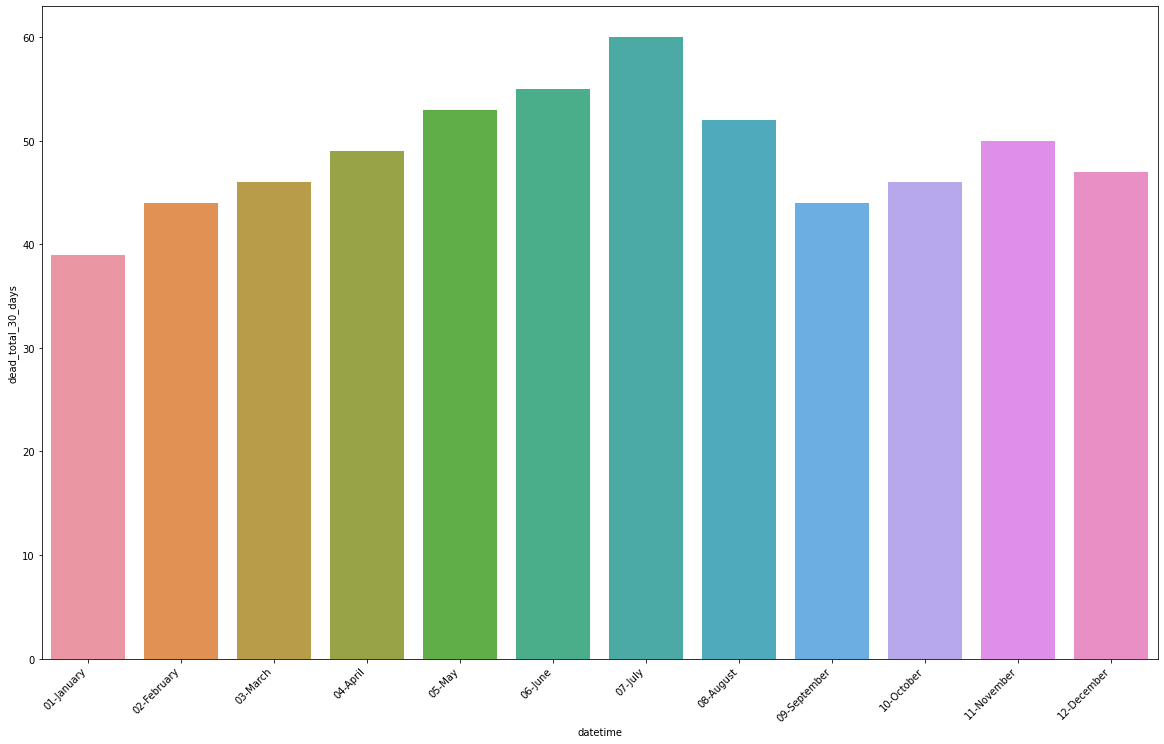

In [ ]:
fig, ax = plt.subplots(figsize = (20,12))    
fig = sns.barplot(x=by_month.index, y="dead_total_30_days", data=by_month, ax=ax)


x_dates = df.index.strftime('%m-%B').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

In [ ]:
# Math the Mode, Median and Mean
mean = df['dead_total_30_days'].mean()
median = df['dead_total_30_days'].median()
mode = df['dead_total_30_days'].mode()[0]

<Figure size 1440x720 with 0 Axes>

Text(0.5, 0, 'Total death')

Text(0, 0.5, 'Incidents')

No handles with labels found to put in legend.


Mean: 0 - Median: 0 - Mode: 0


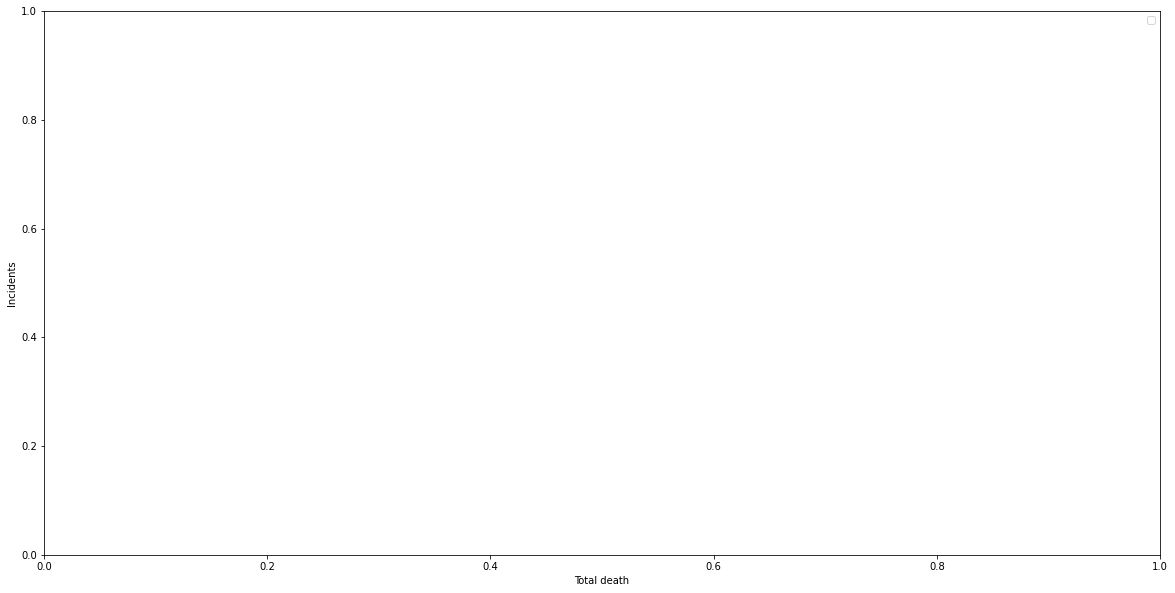

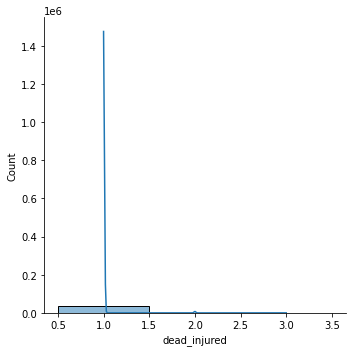

In [ ]:
# Resize the graph size
plt.figure(figsize=(20,10))
plt.ticklabel_format(style='plain', axis='x')

#plt.axvline(mean, color='m', linewidth=3,label='Mean')
#plt.axvline(median, color='b', linestyle='dashed', linewidth=3,label='Median')
#plt.axvline(mode, color='g', linestyle='dashed', linewidth=3,label='Mode')

# Label the axis
plt.xlabel('Total death')
plt.ylabel('Incidents')
plt.legend()

# Show the graph
sns.displot(data=df, x="dead_injured", kde=True, kde_kws={'bw_adjust': 1}, discrete=True)
print(f"Mean: {round(mean)} - Median: {round(median)} - Mode: {round(mode)}")

# plt.savefig('quality.svg', dpi=300, bbox_inches='tight')